In [1]:
! pip install opencv-contrib-python==4.5.5.64

In [5]:
! pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.9 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114250 sha256=da3096a9be6e628d158c0972b8fd4a80b50293f5339fb3d7985cbec8977bad25
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [ ]:
! pip install opencv-python-headless deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.5 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=2546b62e3ed89a56117660c939b4af0745043904ad22fa80fa143abd2d8620dd
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [32]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [33]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [34]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [35]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


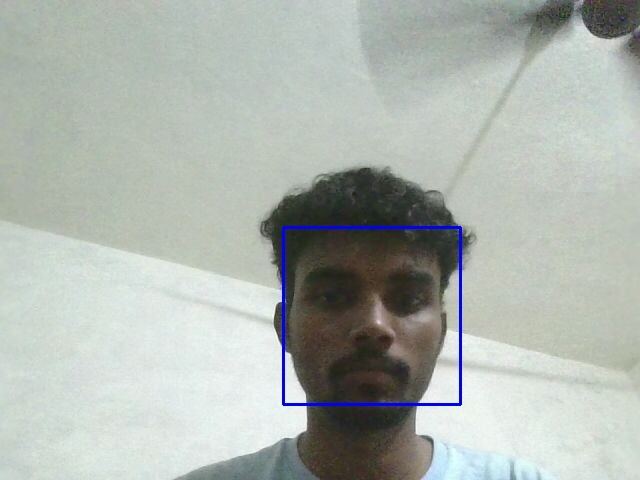

In [36]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [37]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [38]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

# **Real Time face recognition**


In [28]:
! pip install face_recognition opencv-python-headless ipywidgets numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566164 sha256=b25bbd57db29e30e1a6584e81771647f53ef06418765ec9dda01e94ca60802f7
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [41]:
from IPython.display import display, Javascript, HTML, clear_output
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import ipywidgets as widgets
import face_recognition
import time

def setup_video_stream():
    """Setup continuous video stream using JavaScript"""
    js = Javascript('''
        var video;
        var div = null;
        var stream;
        var captureCanvas;
        var imgElement;
        var labelElement;

        var pendingResolve = null;
        var shutdown = false;

        function removeDom() {
            stream.getVideoTracks()[0].stop();
            video.remove();
            div.remove();
            video = null;
            div = null;
            stream = null;
            imgElement = null;
            captureCanvas = null;
            labelElement = null;
        }

        function onAnimationFrame() {
            if (!shutdown) {
                window.requestAnimationFrame(onAnimationFrame);
            }
            if (pendingResolve) {
                var result = "";
                if (!shutdown) {
                    captureCanvas.getContext('2d').drawImage(video, 0, 0);
                    result = captureCanvas.toDataURL('image/jpeg', 0.8)
                }
                var lp = pendingResolve;
                pendingResolve = null;
                lp(result);
            }
        }

        async function createDom() {
            if (div !== null) {
                return stream;
            }
            div = document.createElement('div');
            div.style.border = '2px solid black';
            div.style.padding = '3px';
            div.style.width = '100%';
            div.style.maxWidth = '600px';
            document.body.appendChild(div);

            const modelOut = document.createElement('div');
            modelOut.innerHTML = "<span>Status:</span>";
            labelElement = document.createElement('span');
            labelElement.innerText = 'No data';
            modelOut.appendChild(labelElement);
            div.appendChild(modelOut);

            video = document.createElement('video');
            video.style.display = 'block';
            video.width = div.clientWidth - 6;
            video.setAttribute('playsinline', '');
            video.onclick = () => { shutdown = true; };
            stream = await navigator.mediaDevices.getUserMedia(
                {video: { facingMode: "user" }});
            div.appendChild(video);

            imgElement = document.createElement('img');
            imgElement.style.position = 'absolute';
            imgElement.style.zIndex = 1;
            imgElement.onclick = () => { shutdown = true; };
            div.appendChild(imgElement);

            const instruction = document.createElement('div');
            instruction.innerHTML =
                'Click here to stop the video capture';
            div.appendChild(instruction);
            instruction.onclick = () => { shutdown = true; };

            video.srcObject = stream;
            await video.play();

            captureCanvas = document.createElement('canvas');
            captureCanvas.width = video.videoWidth;
            captureCanvas.height = video.videoHeight;
            window.requestAnimationFrame(onAnimationFrame);

            return stream;
        }

        async function stream_frame(label, imgData) {
            if (shutdown) {
                removeDom();
                shutdown = false;
                return '';
            }

            var preCreate = Date.now();
            stream = await createDom();

            var preShow = Date.now();
            if (label != "") {
                labelElement.innerHTML = label;
            }

            if (imgData != "") {
                var videoRect = video.getBoundingClientRect();
                imgElement.style.top = videoRect.top + "px";
                imgElement.style.left = videoRect.left + "px";
                imgElement.style.width = videoRect.width + "px";
                imgElement.style.height = videoRect.height + "px";
                imgElement.src = imgData;
            }

            var preCapture = Date.now();
            var result = await new Promise(function(resolve, reject) {
                pendingResolve = resolve;
            });
            shutdown = false;

            return {'create': preShow - preCreate,
                   'show': preCapture - preShow,
                   'capture': Date.now() - preCapture,
                   'img': result};
        }
        ''')
    display(js)

def video_frame(label, jpeg_as_text):
    """Get a frame from the video stream"""
    data = eval_js('stream_frame("{}", "{}")'.format(label, jpeg_as_text))
    return data

def js_to_image(js_reply):
    """Convert JS string to OpenCV image"""
    if not js_reply['img']:
        return None
    image_bytes = b64decode(js_reply['img'].split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

class FaceRecognitionSystem:
    def __init__(self):
        # Load known faces
        self.known_face_encodings = []
        self.known_face_names = []
        self.load_known_faces()

    def load_known_faces(self):
        """Load and encode known faces from images"""
        try:
            # Load a sample picture and learn how to recognize it
            biden_image = face_recognition.load_image_file("biden.jpg")
            biden_face_encoding = face_recognition.face_encodings(biden_image)[0]
            self.known_face_encodings.append(biden_face_encoding)
            self.known_face_names.append("Joe Biden")

            print("Known faces loaded successfully!")

        except Exception as e:
            print(f"Error loading known faces: {str(e)}")

    def process_frame(self, frame):
        """Process a single frame for face recognition"""
        if frame is None:
            return None

        # Resize frame for faster face recognition processing
        small_frame = cv2.resize(frame, (0, 0), fx=0.5, fy=0.5)

        # Convert the image from BGR color to RGB color
        rgb_small_frame = cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB)

        # Find all the faces and face encodings in the current frame
        #model used is HOG: Histogram of Oriented Gradients
        face_locations = face_recognition.face_locations(rgb_small_frame, model="hog")
        face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)

        face_names = []
        for face_encoding in face_encodings:
            # See if the face is a match for the known faces
            matches = face_recognition.compare_faces(self.known_face_encodings, face_encoding)
            name = "Unknown"

            if len(self.known_face_encodings) > 0:
                # Use the known face with the smallest distance
                face_distances = face_recognition.face_distance(self.known_face_encodings, face_encoding)
                best_match_index = np.argmin(face_distances)
                if matches[best_match_index]:
                    name = self.known_face_names[best_match_index]

            face_names.append(name)

        # Draw results on the frame
        for (top, right, bottom, left), name in zip(face_locations, face_names):
            # Scale back up face locations
            top *= 2
            right *= 2
            bottom *= 2
            left *= 2

            # Draw a box around the face
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)

            # Draw a label with a name below the face
            cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(frame, name, (left + 6, bottom - 6), font, 0.6, (255, 255, 255), 1)

        return frame

def run_face_recognition():
    """Run the face recognition system"""
    # Initialize the system
    face_system = FaceRecognitionSystem()

    # Setup the video stream
    setup_video_stream()

    # Initialize frame processing
    label_html = 'Capturing...'
    bbox_html = ''
    count = 0

    try:
        while True:
            js_reply = video_frame(label_html, bbox_html)
            if not js_reply:
                break

            frame = js_to_image(js_reply)
            if frame is not None:
                # Process frame for face recognition
                processed_frame = face_system.process_frame(frame)

                if processed_frame is not None:
                    # Convert processed frame to JPEG for display
                    _, jpeg = cv2.imencode('.jpg', processed_frame)
                    bbox_html = f'data:image/jpeg;base64,{b64encode(jpeg).decode()}'

                    # Update label periodically
                    count += 1
                    if count % 10 == 0:
                        label_html = f'Frame {count}'

            # Small delay to prevent overwhelming the browser
            time.sleep(0.05)

    except Exception as e:
        print(f"Error in main loop: {str(e)}")

    finally:
        print("Recognition stopped")

# Run the system
print("Starting face recognition system...")
run_face_recognition()

Starting face recognition system...
Known faces loaded successfully!


<IPython.core.display.Javascript object>

Recognition stopped
